<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 8

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

In [311]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from scipy.linalg import inv
%matplotlib nbagg

<IPython.core.display.Javascript object>


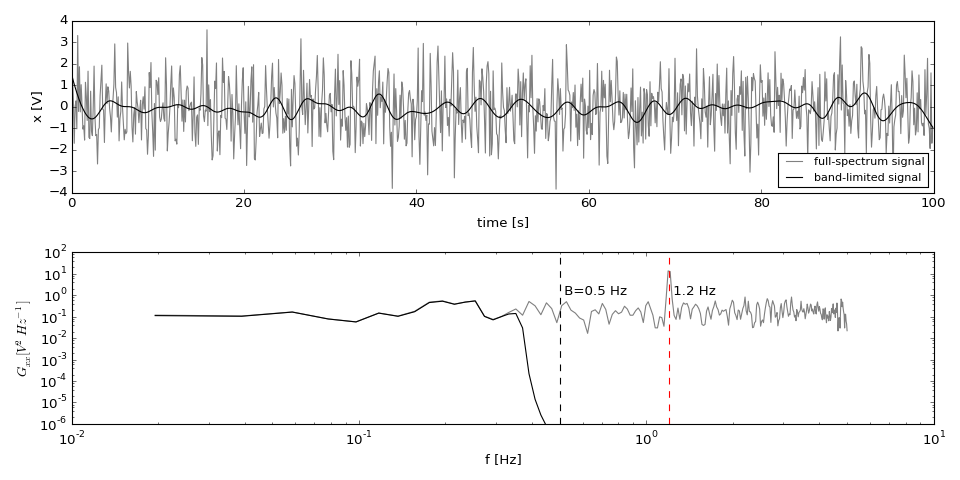

In [312]:
N = 1000
dt = 0.1
# make random noise. 
x0 = np.random.randn(N)
# add a 1.2 Hz signal to x
t = np.arange(0,N*dt,dt)
x0 = x0+1.*np.cos(t*2*np.pi*1.2)
#Bandwidth = 0.5 Hz
B = 0.5
# filter to make Bandlimited signal
fp=B*0.7
fs = B*0.9
fNyq=1/2./dt
n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 60.)
b,a=signal.ellip(n,.1,60.,fn)
xBL = signal.filtfilt(b,a,x0)

fig,ax=plt.subplots(2,1,figsize=(12,6))
ax[0].plot(t,x0,color='0.5',label='full-spectrum signal')
ax[0].plot(t,xBL,color='k',label='band-limited signal')
ax[0].set_xlabel('time [s]');ax[0].set_ylabel('x [V]');ax[0].legend(fontsize='small',loc='best')

nfft=512
pxx,f=mlab.psd(x0,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
pxBL,f=mlab.psd(xBL,NFFT=nfft,Fs=1./dt,noverlap=nfft/2.,window=mlab.window_hanning)
ax[1].loglog(f,pxx,color='0.5')
ax[1].loglog(f,pxBL,color='k')
ax[1].axvline(x=B,linestyle='--',color='k')
ax[1].text(B,1,' B=0.5 Hz')
ax[1].axvline(x=1.2,linestyle='--',color='r')
ax[1].text(1.2,1,' 1.2 Hz')
ax[1].set_ylim([1e-6,1e2])
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')
plt.tight_layout()

<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

<IPython.core.display.Javascript object>


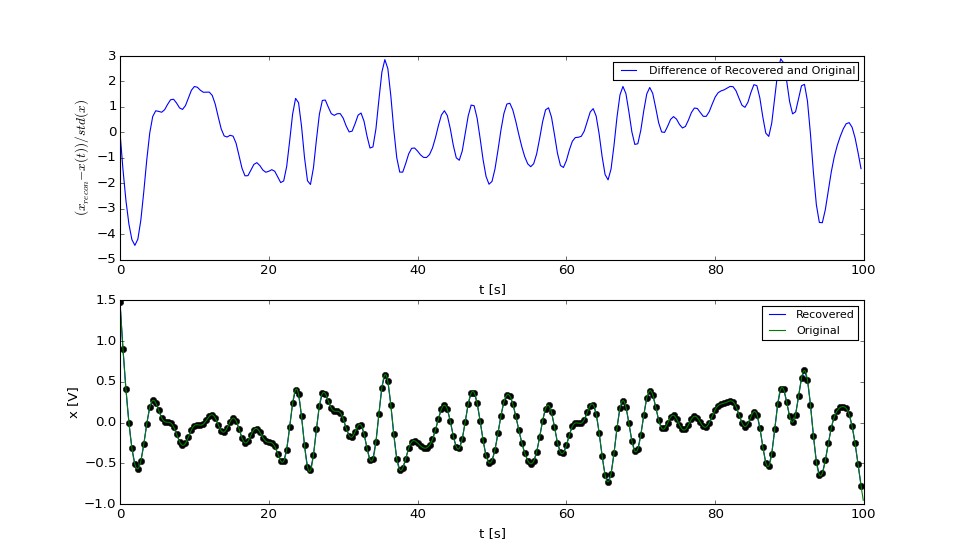

In [313]:
# decimated time series:
tn = t[::4]
xn = xBL[::4]
B = 2.5
n = np.arange(N/4)

fig,ax=plt.subplots(2,1,figsize=(12,7))
# reconstruct the full time series just from the subsampled data xn:  
xreco=1.*xBL[:N/4] # trim the last N*25 data points...
for i in n:
    xreco[i] = np.sum(xn[:N]*np.sinc(2.5*tn[i]-n))
ax[0].plot(tn,(xreco-xBL[:N/4])/np.std(xBL),label='Difference of Recovered and Original')
#plt.xlim([0,50])
ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('$(x_{recon}-x(t))/std(x)$')
#plt.ylim([-1.,1.])
ax[0].legend(fontsize='small')

ax[1].plot(tn,xreco, label='Recovered')
ax[1].plot(tn,xn,'ok')
ax[1].plot(t,xBL, label='Original')
ax[1].legend(fontsize='small')
ax[1].set_xlabel('t [s]')
ax[1].set_ylabel('x [V]')

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

25


<IPython.core.display.Javascript object>


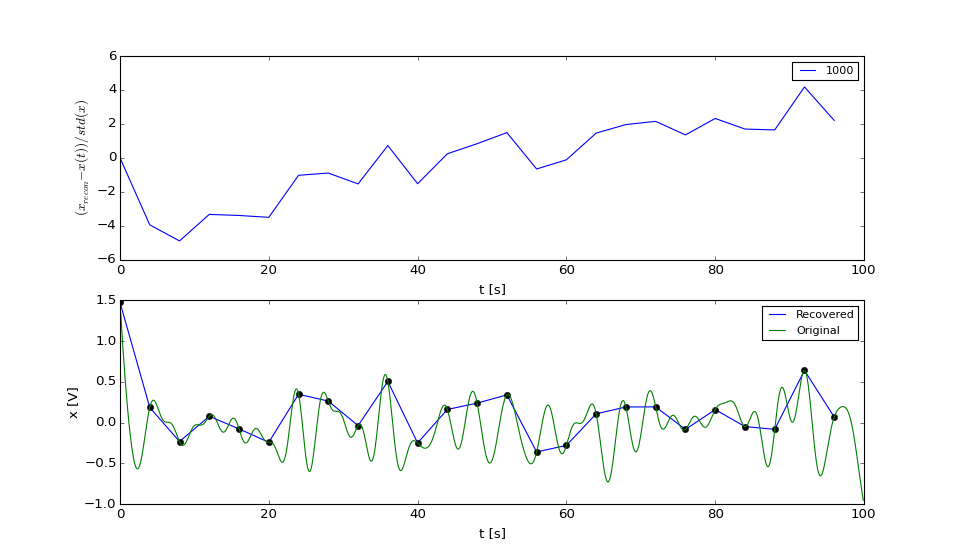

In [314]:
# decimated time series:
tn = t[::40]
xn = xBL[::40]
B = 0.25
n = np.arange(N/40)
print N/40
fig,ax=plt.subplots(2,1,figsize=(12,7))
# reconstruct the full time series just from the subsampled data xn:  
xreco=1.*xBL[:N/40] # trim the last N*25 data points...
for i in n:
    xreco[i] = np.sum(xn[:N]*np.sinc(0.25*tn[i]-n))
ax[0].plot(tn,(xreco-xBL[:N/40])/np.std(xBL),label='%d'%N)
#plt.xlim([0,50])

ax[0].set_xlabel('t [s]')
ax[0].set_ylabel('$(x_{recon}-x(t))/std(x)$')
#plt.ylim([-1.,1.])
ax[0].legend(fontsize='small')

ax[1].plot(tn,xreco, label='Recovered')
ax[1].plot(tn,xn,'ok')
ax[1].plot(t,xBL, label='Original')
ax[1].legend(fontsize='small')
ax[1].set_xlabel('t [s]')
ax[1].set_ylabel('x [V]')

The sample that was decimated by 4 recovered the 10Hz time series because the series was sampled at a value of 2.5Hz which was greater than B = 0.5Hz. This allowed a recovery of the original. When compared to the series decimated by 40, this was sampled at 0.25Hz, a value less than B = 0.5Hz. Thus an aliasing effect was produced from this sampling. This also makes sense because when you decimate by 4, you are given more data points to work with, and when you use 40, there are less points so it is hard to recover.

## Q2: Cubic Spline

Using the data below...

In [315]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x = np.cos(t*2*np.pi/3)

**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [317]:
NN = x.size #7
Nn = NN - 1 #6

M = np.zeros([NN,NN])
x_array = np.zeros(NN)

M[0,0] = 1.
M[Nn,Nn] = 1.
for i in range(1,Nn):
    x_array[i] = 3*((x[i+1]-x[i])/(t[i+1]-t[i])) - 3*((x[i]-x[i-1])/(t[i]-t[i-1]))
    for j in range(1,Nn):
        if i == j:
            M[i,i-1] = t[i]-t[i-1]
            M[i,i] = 2*t[i+1]-2*t[i-1]
            M[i,i+1] = t[i+1]-t[i]
#Determines the inverse of M
m = inv(M)
c = np.dot(m,x_array)

In [318]:
#finding b's and d's
d = np.zeros(Nn)
b = np.zeros(Nn)
#Special Case where d[5] is found
d[Nn-1] = -1.*c[Nn-1]/(3*(t[Nn]-t[Nn-1]))

for i in range(Nn-1):
    d[i] = (c[i+1] - c[i]) / (3*(t[i+1]-t[i]) )
for i in range(Nn):
    b[i] = ((x[i+1]-x[i]) - c[i]*(t[i+1]-t[i])**2 -d[i]*(t[i+1]-t[i])**3) / (t[i+1]-t[i])

In [320]:
#allows us to find 20 time-points between x-points
pp = 20
q = np.zeros([Nn,pp])
ttq = np.zeros([Nn,pp])
for i in range(Nn):
    tq = np.linspace(t[i],t[i+1],pp)
    ttq[i,] = tq
    for j in range(pp):
        q[i,j] = x[i] + b[i]*(tq[j]-t[i]) + c[i]*(tq[j]-t[i])**2 + d[i]*(tq[j]-t[i])**3

qq = q.flatten()
time = ttq.flatten()

<IPython.core.display.Javascript object>


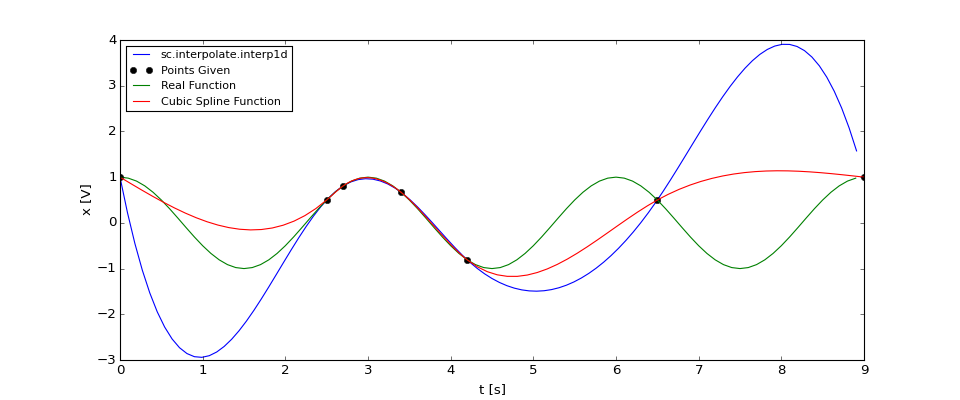

In [324]:
f = sc.interpolate.interp1d(t, x, kind='cubic')
tf = np.arange(0, 9, 0.09)
y = f(tf)
tt = np.arange(0,9,0.1)

fig,ax=plt.subplots(1,1, figsize=(12,5))
ax.plot(tf,y,label='sc.interpolate.interp1d')
ax.plot(t,x,'ok',label='Points Given')
ax.plot(tt,np.cos(tt*2*np.pi/3),label='Real Function')
ax.plot(time,qq, label='Cubic Spline Function')
plt.xlabel('t [s]')
plt.ylabel('x [V]')
plt.legend(fontsize='small', loc='best')

From the two results it can be seen that the sc.interpolate.interp1d function produces a larger error than our cubic spline function. The two methods agree with the original function failry well from the second point to the fourth point, due to a small gap between the points. This however is not seen as one distances themselves from those points. The sc.interpolate.interp1d function becomes large when there is a large gap between data points, this is opposite for the cubic spline function where is seems to flatten itself as much as possible. They are similar in that they almost share the same phase, in otherwords, when one is at a maximum or minimum, so is the other. 